In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from fbprophet import Prophet


# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-057088e0c8b3>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [3]:
# Only use pre-COVID data for time series modeling
df_TS_preCOV = df_TS.loc[:'2020-3-13']


In [4]:
# Create df of only Brooklyn data, remove all columns other than accident counts 
df_prophet = df_TS_preCOV.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_SI',
                               'Accidents_Total','Season','Day of Week', 'Weekend','Holiday'])

# Rename columns to [ds,y] per fb prophet specifications
df_prophet['ds'] = df_prophet.index
df_prophet.rename(columns={'Accidents_Bkln': 'y'},inplace=True)


In [5]:
df_prophet.head()

,y,ds
Date,,
2012-07-01,140.0,2012-07-01
2012-07-02,146.0,2012-07-02
2012-07-03,176.0,2012-07-03
2012-07-04,104.0,2012-07-04
2012-07-05,158.0,2012-07-05


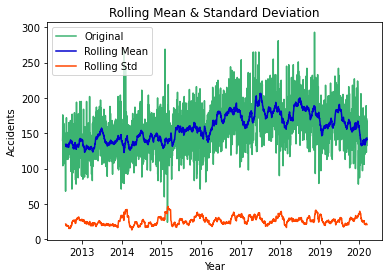

Test Statistic                   -3.239439
p-value                           0.017812
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [6]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_prophet['y'].rolling(window=30, center=False).mean()
roll_std = df_prophet['y'].rolling(window=30, center=False).std()

plt.plot(df_prophet['y'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_prophet['y'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# Facebook Prophet Modeling

## Train-Test Split

In [7]:
# Train-test split
# 2019-06-06 will be the split point for our train and test sets, which is a 90%/10% split

X = df_prophet.index
y = df_prophet['y']

train = df_prophet.loc[:'2019-06-06']
test = df_prophet.loc['2019-06-07':]

X_train, X_test = train.index , test.index
y_train, y_test = train['y'] , test['y']

## Fit Model and Generate Predictions

In [8]:
# Fit model to data
model = Prophet(interval_width=0.95)
model.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# Make predictions 1120 days into the future--ie until 6/30/22
# This way we will have a full year of model-predicted data after starting on 7/1/21
# Create future dates
future_dates = model.make_future_dataframe(periods=1120, freq='D')

# Generate predictions
forecast = model.predict(future_dates)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3647,2022-06-26,148.542111,85.102547,189.175687,121.270843,174.039511,-10.712950,-10.712950,-10.712950,-25.736374,-25.736374,-25.736374,15.023424,15.023424,15.023424,0.0,0.0,0.0,137.829161
3648,2022-06-27,148.522521,116.168163,221.397530,121.230013,174.048195,20.450180,20.450180,20.450180,6.688528,6.688528,6.688528,13.761652,13.761652,13.761652,0.0,0.0,0.0,168.972701
3649,2022-06-28,148.502930,114.773245,222.441096,121.189183,174.056879,20.422675,20.422675,20.422675,8.004963,8.004963,8.004963,12.417712,12.417712,12.417712,0.0,0.0,0.0,168.925606
3650,2022-06-29,148.483340,114.026376,216.424607,121.148353,174.065562,15.663355,15.663355,15.663355,4.646392,4.646392,4.646392,11.016963,11.016963,11.016963,0.0,0.0,0.0,164.146695
3651,2022-06-30,148.463750,116.966609,220.304765,121.107523,174.074246,17.836728,17.836728,17.836728,8.250894,8.250894,8.250894,9.585834,9.585834,9.585834,0.0,0.0,0.0,166.300478


## Visualize Model

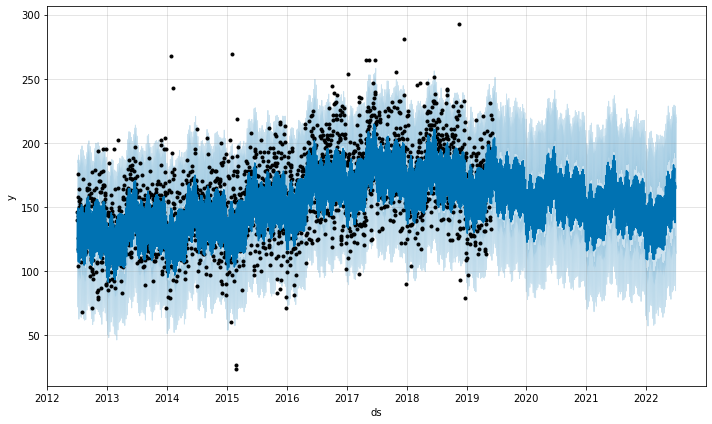

In [10]:
# Subset useful columns from forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot forecast
model.plot(forecast,uncertainty=True)
plt.show()

## Assess Model

In [11]:
# Assess model using RMSE to compare to our working ARIMA model
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# Define test predictions
test_preds = forecast.set_index('ds').loc['2019-06-07':'2020-03-13']

# Define fb prophet RMSE
fb_RMSE = RMSE(test_preds['yhat'])

# Compare to ARIMA RMSE to determine the better model
print('FB Prophet RMSE: ', fb_RMSE)
print('ARIMA RMSE: ', 29.358338851353853)

FB Propher RMSE:  24.44112937646152
ARIMA RMSE:  29.358338851353853


Based on the above RMSEs, we see that our FB Prophet model performs 17% better than our ARIMA model. There is no need to adjust RMSE for range since these are based on the same test data.

In [ ]:
# Although there is no need to view adjusted RMSE for purposes of comparing models, it is still helpful to see how


## Adjust Predictions to Account for COVID

The above represents accident frequency predictions assuming the COVID-19 pandemic had not occured. Now we will adjust our predictions in the same way we did for our ARIMA model.

In [12]:
# Create Brooklyn dataframe with all known data, not only pre-COVID
df_bkln_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_SI',
                               'Accidents_Total'])

# Create line connecting end of known data to predicted July data

# Begin model-based predictions on 7/1/21, diminish by 25%.
TS_pred_cov = forecast.set_index('ds').loc['2021-07-01':'2022-06-30']['yhat'] * 0.75

# Since there is more varibility in this model than there was in the ARIMA one and there is weekly seasonality,
# make 6/30/21 values the same as 7/7/2021 since they are the same day of the week
june_30 = TS_pred_cov.loc['2021-07-07']

# Create df for connection data
connection = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))

# Find how much the accident count will rise each day
# There are 151 days between 1/29/21 and 6/30/21
daily_interval=(june_30 - df_bkln_total['Accidents_Bkln']['2021-01-29'])/151

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_bkln_total['Accidents_Bkln']['2021-01-29']
for num in range(0,151):
    i+=daily_interval
    connection_forecasts.append(i)
    
# Add 6/30/21 to forecases
connection_forecasts.append(june_30)
    
# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts

# Make date index of connection df
connection.set_index('Date', inplace=True)
connection.drop(columns=0,inplace=True)

#Observe connection df
connection

,Forecast
Date,
2021-01-30,64.374677
2021-01-31,64.749355
2021-02-01,65.124032
2021-02-02,65.498709
2021-02-03,65.873387
...,...
2021-06-26,119.452245
2021-06-27,119.826922
2021-06-28,120.201600


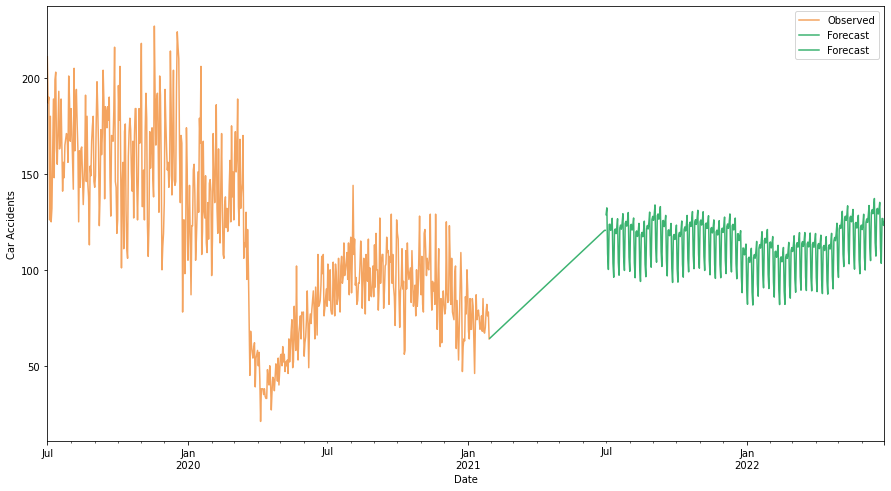

In [13]:
fix,ax = plt.subplots(figsize=(15,8))

# Plot known data
ax = df_bkln_total['Accidents_Bkln']['2019-07-01':].plot(label='Observed', color='sandybrown')

# Plot predicted data based on model, starting 7/1/20, 75% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast', color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

Note we specifically did not include a confidence interval because this would be misleading given that it would not account for the uncertainty associated with the way we produced our predictions in regards to COVID-affected data.

# Export Data

In [14]:
# Create one df combining known and predicted accident frequencies
# Round forecasts to integers 
data_preds_bkln = pd.concat([df_bkln_total['Accidents_Bkln'],connection['Forecast'].astype(int),TS_pred_cov.astype(int)])


In [15]:
# Export data
data_preds_bkln.to_csv('Data/data_preds_bkln.csv')